# **酒店预订数据集探究**

该数据集包含预订的提前天数、酒店类型、是否取消等维度。对该数据集做了以下探究：

1. 抽取感兴趣的维度，查看其中的取值分布情况；
2. 就“提前天数”和“是否取消”这两个维度的相关性做了探究

In [ ]:
#将工作区域切换至包含数据集的区域
%cd drive/My\ Drive

/content/drive/My Drive


In [ ]:
#读取csv数据集，查看原始数据集
import pandas as pd
hb = pd.read_csv('hotel_bookings.csv')
hb

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


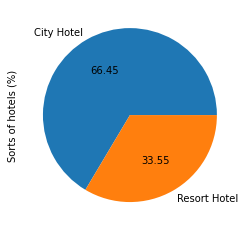

In [ ]:
#查看酒店类型的取值分布
gp_hotel = hb.groupby('hotel').size()
gp_hotel.name = 'Sorts of hotels (%)'
gp_hotel.plot.pie(autopct='%.2f')

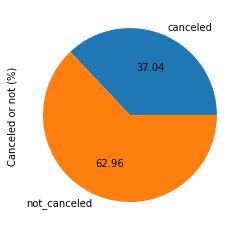

In [ ]:
#查看是否取消的取值分布，需先将数据按照"键：值"处理
hb['is_canceled'] = hb['is_canceled'].map({1: 'canceled', 0: 'not_canceled'})

gp_cancel = hb.groupby('is_canceled').size()
gp_cancel.name = 'Canceled or not (%)'
gp_cancel.plot.pie(autopct='%.2f')

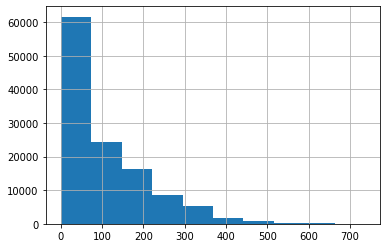

In [ ]:
#查看提前天数的取值分布
hb['lead_time'].hist()

In [ ]:
'''
查看各个维度之间的相关程度，由于含有类别取值，corr函数采用kendall类型
暂时略去含字符取值的维度，若需要查看，可先将该维度按"键：值"处理
'''
hb['is_canceled'] = hb['is_canceled'].map({'canceled': 1, 'not_canceled': 0})
corr = hb.corr(method='kendall')
corr

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.259528,0.017181,0.006258,-0.005096,-0.003850,0.036872,0.065604,-0.002766,-0.034304,-0.084793,0.269762,-0.114679,-0.181956,-0.098736,-0.009430,0.097492,0.041656,-0.197370,-0.247219
lead_time,0.259528,1.000000,0.044102,0.083628,0.005224,0.125971,0.217601,0.153399,-0.013148,-0.016213,-0.155889,0.139784,-0.153624,-0.006296,-0.086272,0.190327,0.125113,0.006938,-0.116004,-0.057681
arrival_date_year,0.017181,0.044102,1.000000,-0.421526,-0.000917,0.022199,0.035033,0.039839,0.054570,-0.012620,0.009868,-0.244617,0.034296,0.021101,0.087808,0.186443,-0.078468,0.172775,-0.015500,0.105513
arrival_date_week_number,0.006258,0.083628,-0.421526,1.000000,0.051529,0.019647,0.019194,0.020991,0.005229,0.010343,-0.025053,0.071557,-0.035314,0.006362,-0.040696,-0.035959,-0.002911,0.056859,0.002588,0.015370
arrival_date_day_of_month,-0.005096,0.005224,-0.000917,0.051529,1.000000,-0.005251,-0.011498,0.001201,0.012874,0.000381,-0.005047,-0.009897,-0.001137,0.010161,0.003338,0.031391,0.026518,0.018192,0.007056,0.002447
stays_in_weekend_nights,-0.003850,0.125971,0.022199,0.019647,-0.005251,1.000000,0.199208,0.116289,0.049122,0.021283,-0.091022,-0.051457,-0.077926,0.037217,0.105666,0.060771,-0.069546,0.039543,-0.017455,0.071220
stays_in_week_nights,0.036872,0.217601,0.035033,0.019194,-0.011498,0.199208,1.000000,0.133409,0.047921,0.023554,-0.114306,-0.055306,-0.105315,0.056389,0.132458,0.193980,0.010482,0.069736,-0.030137,0.064748
adults,0.065604,0.153399,0.039839,0.020991,0.001201,0.116289,0.133409,1.000000,0.069921,0.027078,-0.173217,-0.035187,-0.203971,-0.081889,-0.046186,0.190644,-0.035458,0.226901,0.017529,0.151581
children,-0.002766,-0.013148,0.054570,0.005229,0.012874,0.049122,0.047921,0.069921,1.000000,0.038917,-0.034421,-0.058023,-0.034680,0.064194,0.033276,0.023117,-0.047295,0.216526,0.060429,0.090657
babies,-0.034304,-0.016213,-0.012620,0.010343,0.000381,0.021283,0.023554,0.027078,0.038917,1.000000,-0.009423,-0.017255,-0.011045,0.114076,0.037099,0.016104,-0.014005,0.021362,0.040568,0.088765


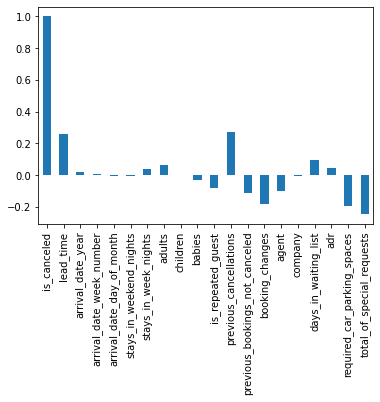

In [ ]:
#查看与"是否取消"这一维度相关性较强的维度
corr['is_canceled'].plot(kind='bar')

可见，即使是与“是否取消”相关性较强的维度，如“提前天数”，相关性也只有0.2左右

可猜想：或许可以通过几个相关性较强的维度，对“是否取消”进行多元线性回归

不过暂时没做回归分析，在此仅对“是否取消”和“提前天数”的关系做探究

In [ ]:
#统计各提前天数区间对应的预订量
lead_time_all = pd.cut(hb['lead_time'], range(0, 801, 100))
lt_all = pd.DataFrame({'lead_time': lead_time_all})
num_lt_all = lt_all.groupby('lead_time').size()
num_lt_all

lead_time
(0, 100]      65685
(100, 200]    26713
(200, 300]    12760
(300, 400]     5773
(400, 500]     1633
(500, 600]      334
(600, 700]      145
(700, 800]        2
dtype: int64

In [ ]:
#统计各提前天数区间对应的预订取消量
lead_time_canceled = pd.cut(hb[hb['is_canceled'] == 1]['lead_time'], range(0, 801, 100))
lt_canceled = pd.DataFrame({'lead_time': lead_time_canceled})
num_lt_canceled = lt_canceled.groupby('lead_time').size()
num_lt_canceled

lead_time
(0, 100]      19575
(100, 200]    12005
(200, 300]     6804
(300, 400]     3902
(400, 500]     1096
(500, 600]      267
(600, 700]      145
(700, 800]        0
dtype: int64

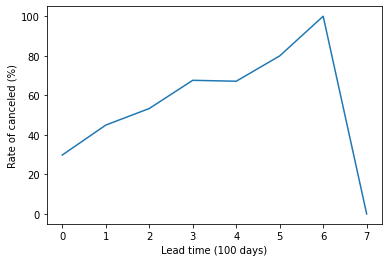

In [ ]:
#计算各提前天数区间对应的取消率，用图展示
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(rate_canceled * 100)
ax.set_xlabel('Lead time (100 days)')
ax.set_ylabel('Rate of canceled (%)')
plt.show()

可见，随着提前天数增加，取消率有增加趋势。曲线尾部的下降是2个异常订单导致，数量少，不具备代表性